In [28]:
import os
import pickle
import torch
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict, Counter
from abc import ABC, abstractmethod
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

warnings.filterwarnings('ignore', message='.*sklearn.utils.parallel.delayed.*', category=UserWarning)

In [29]:
class BaseRecommender(ABC):
    def __init__(self, name):
        self.name = name
        self.train_df = None
        
    @abstractmethod
    def fit(self, train_df):
        """Treina o modelo com os dados de treino."""
        pass
    
    @abstractmethod
    def recommend(self, author_id, top_n=10):
        """Retorna uma lista de author_ids recomendados."""
        pass

In [30]:
class CommonCoauthorsRecommender(BaseRecommender):
    def __init__(self):
        super().__init__("Common Coauthors Count (DataFrame)")
        self.dataset_df = None
        self.coauthor_index = defaultdict(set)  # Índice invertido para acesso rápido
        self.popular_authors = []
        
    def fit(self, train_df):
        self.train_df = train_df
        print(f"[{self.name}] Construindo dataframe de coautorias...")
        
        # Construir dicionário de contagem de coautorias
        coauthor_count = {}
        coauthor_graph = defaultdict(set)
        
        for work_id, group in train_df.groupby("work_id"):
            authors = group["author_id"].tolist()
            if len(authors) > 1:
                for a, b in itertools.combinations(authors, 2):
                    pair = (min(a, b), max(a, b))
                    coauthor_count[pair] = coauthor_count.get(pair, 0) + 1
                    coauthor_graph[a].add(b)
                    coauthor_graph[b].add(a)
        
        # Criar dataframe com pares de coautores e número de coautores em comum
        rows = []
        for (author_a, author_b), count in coauthor_count.items():
            coauthors_a = coauthor_graph.get(author_a, set())
            coauthors_b = coauthor_graph.get(author_b, set())
            common_coauthors = (coauthors_a & coauthors_b) - {author_a, author_b}
            common_count = len(common_coauthors)
            
            rows.append({
                "author_a": author_a, 
                "author_b": author_b, 
                "count_coauthors": count,
                "common_coauthors": common_count
            })
        
        self.dataset_df = pd.DataFrame(rows)
        
        # Construir índice invertido para acesso rápido aos coautores (derivado do dataframe)
        # Isso evita filtrar o dataframe repetidamente - MUITO MAIS RÁPIDO!
        print(f"[{self.name}] Construindo índice invertido para acesso rápido...")
        for _, row in self.dataset_df.iterrows():
            author_a = row['author_a']
            author_b = row['author_b']
            self.coauthor_index[author_a].add(author_b)
            self.coauthor_index[author_b].add(author_a)
        
        # Cálculo de Popularidade (para fallback) - usando o grafo temporário
        popularity_counter = Counter()
        for author, neighbors in coauthor_graph.items():
            popularity_counter[author] = len(neighbors)
        self.popular_authors = [auth for auth, _ in popularity_counter.most_common()]
        
        print(f"[{self.name}] DataFrame construído com {len(self.dataset_df):,} pares de coautores.")
        print(f"[{self.name}] Índice invertido construído com {len(self.coauthor_index):,} autores.")

    def recommend(self, author_id, top_n=10):
        recommendations = []
        
        # Usar o índice invertido ao invés de filtrar o dataframe (muito mais rápido)
        current_coauthors = self.coauthor_index.get(author_id, set())
        
        # Lógica de Amigos em Comum (2 hops) usando o índice invertido
        if len(current_coauthors) > 0:
            candidate_scores = Counter()
            
            # Para cada coautor direto do autor
            for neighbor in current_coauthors:
                # Usar o índice invertido para encontrar coautores desse coautor (muito mais rápido)
                neighbors_of_neighbor = self.coauthor_index.get(neighbor, set())
                
                # Para cada coautor do coautor (2 hops)
                for candidate in neighbors_of_neighbor:
                    # Excluir o próprio autor e seus coautores diretos
                    if candidate != author_id and candidate not in current_coauthors:
                        candidate_scores[candidate] += 1
            
            # Ordenar por número de coautores em comum (maior para menor)
            recommendations = [candidate for candidate, _ in candidate_scores.most_common(top_n)]
        
        # Fallback: completar com autores populares se necessário
        if len(recommendations) < top_n:
            for pop in self.popular_authors:
                if pop != author_id and pop not in recommendations and pop not in current_coauthors:
                    recommendations.append(pop)
                    if len(recommendations) >= top_n:
                        break
        
        return recommendations[:top_n]


In [31]:
from collections import defaultdict, Counter
import itertools

class TopologyRecommender(BaseRecommender):
    def __init__(self):
        super().__init__("Topology (Graph Coauthor)")
        self.graph = defaultdict(set)
        self.popular_authors = []
        
    def fit(self, train_df):
        self.train_df = train_df
        print(f"[{self.name}] Construindo grafo...")
        
        # Construção do Grafo (CORRIGIDO: Agora bidirecional)
        for _, group in train_df.groupby('work_id'):
            authors = group['author_id'].tolist()
            if len(authors) > 1:
                for u, v in itertools.combinations(authors, 2):
                    self.graph[u].add(v)
                    self.graph[v].add(u)  # <--- Apenas esta linha foi adicionada
        
        # Cálculo de Popularidade (para fallback)
        popularity_counter = Counter()
        for author, neighbors in self.graph.items():
            popularity_counter[author] = len(neighbors)
        self.popular_authors = [auth for auth, _ in popularity_counter.most_common()]
        print(f"[{self.name}] Grafo construído com {len(self.graph)} autores.")

    def recommend(self, author_id, top_n=10):
        recommendations = []
        current_coauthors = self.graph.get(author_id, set())
        
        # Determinar se top_n é negativo (modo mínimo)
        is_minimum_mode = top_n < 0
        target_n = abs(top_n) if is_minimum_mode else top_n
        
        # Lógica de Amigos em Comum (2 hops) - Sem otimização de memória
        if author_id in self.graph:
            candidates = []
            for neighbor in current_coauthors:
                neighbors_of_neighbor = self.graph.get(neighbor, set())
                for candidate in neighbors_of_neighbor:
                    if candidate != author_id and candidate not in current_coauthors:
                        candidates.append(candidate)
            
            if is_minimum_mode:
                recommendations = [c[0] for c in Counter(candidates).most_common()]
            else:
                recommendations = [c[0] for c in Counter(candidates).most_common(top_n)]
        
        # Fallback: Populares
        if len(recommendations) < target_n:
            for pop in self.popular_authors:
                if pop != author_id and pop not in recommendations and pop not in current_coauthors:
                    recommendations.append(pop)
                    if len(recommendations) >= target_n:
                        break
        
        if not is_minimum_mode:
            return recommendations[:top_n]
        else:
            return recommendations

In [32]:
database_path = 'database_50k'
authors_df = pd.read_csv(f'{database_path}/authorships.csv')
works_df = pd.read_csv(f'{database_path}/works.csv')

merged_df = authors_df.merge(
    works_df[['id', 'publication_date', 'title', 'abstract', 'language']], 
    left_on='work_id', right_on='id'
)
merged_df['publication_date'] = pd.to_datetime(merged_df['publication_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['publication_date', 'author_id', 'title', 'abstract', 'language']).drop(columns=['id'])
merged_df = merged_df[merged_df['language'] == 'en']

# Divisão Temporal: 80% Treino, 20% Teste
print("Dividindo dados temporalmente (80/20)...")
unique_works = merged_df[['work_id', 'publication_date']].drop_duplicates().sort_values('publication_date')
total_works = len(unique_works)

split_train = int(total_works * 0.8)

train_work_ids = set(unique_works.iloc[:split_train]['work_id'])
test_work_ids = set(unique_works.iloc[split_train:]['work_id'])

train_df = merged_df[merged_df['work_id'].isin(train_work_ids)]
test_df = merged_df[merged_df['work_id'].isin(test_work_ids)]

print(f"\n=== RESUMO DO SPLIT ===")
print(f"Trabalhos no Treino: {len(train_work_ids)}")
print(f"Trabalhos no Teste: {len(test_work_ids)}")
print(f"Total de Autores no Treino: {len(set(train_df['author_id']))}")
print(f"Total de Autores no Teste: {len(set(test_df['author_id']))}")

def build_graph(df):
    graph = defaultdict(set)
    for _, group in df.groupby('work_id'):
        authors = group['author_id'].tolist()
        
        if len(authors) > 1:
            for u, v in itertools.combinations(authors, 2):
                graph[u].add(v)

    return graph

# Construir grafos para avaliação
train_graph = build_graph(train_df)
test_graph_raw = build_graph(test_df)

# Ground truth para teste: novos links que apareceram no teste mas não no treino
test_ground_truth = defaultdict(set)
for author, coauthors in test_graph_raw.items():
    future_coauthors = coauthors
    past_coauthors = train_graph.get(author, set())
    new_links = future_coauthors - past_coauthors
    
    if new_links:
        test_ground_truth[author] = new_links

print(f"\nAutores alvo no teste (com novos links): {len(test_ground_truth)}")

C:\Users\BSBCo\AppData\Local\Temp\ipykernel_24416\2237052165.py:3: DtypeWarning: Columns (0: is_retracted) have mixed types. Specify dtype option on import or set low_memory=False.
  works_df = pd.read_csv(f'{database_path}/works.csv')


Dividindo dados temporalmente (80/20)...

=== RESUMO DO SPLIT ===
Trabalhos no Treino: 19916
Trabalhos no Teste: 4980
Total de Autores no Treino: 25262
Total de Autores no Teste: 11441

Autores alvo no teste (com novos links): 10007


In [33]:
def calculate_ndcg(recommended_list, relevant_set, k):
    """
    Calcula o NDCG@k (Normalized Discounted Cumulative Gain).

    Args:
        recommended_list: Lista de itens recomendados (ordenados)
        relevant_set: Conjunto de itens relevantes (ground truth)
        k: Número de itens a considerar (top-k)

    Returns:
        NDCG@k score (0.0 a 1.0)
    """
    if len(relevant_set) == 0:
        return 0.0

    # DCG: Discounted Cumulative Gain
    dcg = 0.0
    for i, item in enumerate(recommended_list[:k], 1):
        if item in relevant_set:
            dcg += 1.0 / np.log2(i + 1)

    # IDCG: Ideal DCG (ordenando os relevantes primeiro)
    idcg = 0.0
    num_relevant = min(len(relevant_set), k)
    for i in range(1, num_relevant + 1):
        idcg += 1.0 / np.log2(i + 1)

    # NDCG = DCG / IDCG
    if idcg == 0:
        return 0.0
    return dcg / idcg


def calculate_mrr_at_k(recommended_list, relevant_set, k):
    """
    Calcula o MRR@k (Mean Reciprocal Rank at k).

    O MRR@k só considera o primeiro item relevante se ele aparecer dentro das
    primeiras k posições. Se o primeiro relevante aparecer após a posição k,
    o MRR@k é 0.

    Args:
        recommended_list: Lista de itens recomendados (ordenados)
        relevant_set: Conjunto de itens relevantes (ground truth)
        k: Número máximo de posições a considerar (top-k)

    Returns:
        Reciprocal Rank@k (1/rank do primeiro relevante dentro de k, ou 0 se nenhum relevante)
    """
    if len(relevant_set) == 0:
        return 0.0

    # Considera apenas as primeiras k posições
    for rank, item in enumerate(recommended_list[:k], 1):
        if item in relevant_set:
            return 1.0 / rank

    return 0.0


def evaluate_models(models, test_ground_truth, train_graph_check, K_values=[5, 10]):
    results = {}

    # 1. Definir o maior K necessário para a avaliação
    max_k_eval = max(K_values)

    # 2. Definir um "Buffer" de busca.
    # Pedimos 2x ou 3x mais itens para garantir que, após remover
    # os coautores antigos, ainda sobrem itens suficientes para encher o max_k_eval.
    search_limit = max_k_eval * 3

    for model in models:
        print(f"\nAvaliando modelo: {model.name}...")
        model_metrics = {
            k: {"precision": [], "recall": [], "ndcg": [], "mrr": []} for k in K_values
        }

        # Adicionar barra de progresso com tqdm
        total_authors = len(test_ground_truth)
        for author_id, actual_new_coauthors in tqdm(
            test_ground_truth.items(),
            desc=f"  {model.name}",
            total=total_authors,
            unit="autor",
        ):
            # SOLICITAÇÃO EXPANDIDA: Pede mais itens do que o necessário
            recs = model.recommend(author_id, top_n=search_limit)

            # FILTRAGEM: Remove coautores que já existem no treino
            past_coauthors = train_graph_check.get(author_id, set())
            valid_recs = [r for r in recs if r not in past_coauthors]

            # CORTE FINAL: Garante que a lista tenha no máximo o tamanho do maior K avaliado
            # Isso garante consistência: estamos avaliando as melhores "valid_recs" disponíveis
            valid_recs = valid_recs[:max_k_eval]

            for k in K_values:
                # O top_k aqui é seguro, pois valid_recs já está limpo
                top_k_recs = valid_recs[:k]

                hits = len(set(top_k_recs) & actual_new_coauthors)

                # Métricas padrão
                p = hits / k if k > 0 else 0
                r = (
                    hits / len(actual_new_coauthors)
                    if len(actual_new_coauthors) > 0
                    else 0
                )
                ndcg = calculate_ndcg(top_k_recs, actual_new_coauthors, k)
                mrr = calculate_mrr_at_k(
                    valid_recs, actual_new_coauthors, k
                )  # MRR usa a lista até K implícito

                model_metrics[k]["precision"].append(p)
                model_metrics[k]["recall"].append(r)
                model_metrics[k]["ndcg"].append(ndcg)
                model_metrics[k]["mrr"].append(mrr)

        # Consolidação dos resultados (Média)
        results[model.name] = {}
        for k in K_values:
            avg_p = np.mean(model_metrics[k]["precision"])
            avg_r = np.mean(model_metrics[k]["recall"])
            avg_ndcg = np.mean(model_metrics[k]["ndcg"])
            avg_mrr = np.mean(model_metrics[k]["mrr"])
            f1 = 2 * (avg_p * avg_r) / (avg_p + avg_r) if (avg_p + avg_r) > 0 else 0

            results[model.name][k] = {
                "P": avg_p,
                "R": avg_r,
                "F1": f1,
                "NDCG": avg_ndcg,
                "MRR": avg_mrr,
            }
            print(
                f"  K={k}: Precision={avg_p:.4f}, Recall={avg_r:.4f}, F1={f1:.4f}, NDCG={avg_ndcg:.4f}, MRR@k={avg_mrr:.4f}"
            )

    return results

def plot_model_comparison(results, figsize=(25, 5)):
    model_names = list(results.keys())
    k_values = sorted([k for k in results[model_names[0]].keys() if isinstance(k, int)])
    
    # Preparar dados para cada métrica
    metrics_data = {
        'Precision': {model: [results[model][k]['P'] for k in k_values] for model in model_names},
        'Recall': {model: [results[model][k]['R'] for k in k_values] for model in model_names},
        'F1-Score': {model: [results[model][k]['F1'] for k in k_values] for model in model_names},
        'NDCG': {model: [results[model][k]['NDCG'] for k in k_values] for model in model_names},
        'MRR@k': {model: [results[model][k]['MRR'] for k in k_values] for model in model_names}
    }
    
    # Criar figura com 5 subplots para métricas dependentes de K
    fig, axes = plt.subplots(1, 5, figsize=figsize)
    fig.suptitle('Comparação de Modelos de Link Prediction', fontsize=16, fontweight='bold')
    
    # Cores e estilos para cada modelo
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    markers = ['o', 's', '^', 'D', 'v']
    
    # Plotar cada métrica dependente de K
    for idx, (metric_name, data) in enumerate(metrics_data.items()):
        ax = axes[idx]
        
        for i, model in enumerate(model_names):
            ax.plot(
                k_values, 
                data[model], 
                marker=markers[i % len(markers)],
                label=model,
                color=colors[i % len(colors)],
                linewidth=2,
                markersize=8
            )
        
        ax.set_xlabel('K (Top-K)', fontsize=11)
        ax.set_ylabel(metric_name, fontsize=11)
        ax.set_title(f'{metric_name} por K', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=9)
        ax.set_xticks(k_values)
        
    plt.tight_layout()
    plt.show()
    
    return fig

In [34]:
# Treinar modelos
print("="*60)
print("TREINANDO MODELOS")
print("="*60)

topo_model = TopologyRecommender()
common_coauthors_model = CommonCoauthorsRecommender()

models = [
    topo_model,
    common_coauthors_model
]

for model in models:
    model.fit(train_df)
    
print("\n" + "="*60)
print("AVALIANDO MODELOS NO TESTE")
print("="*60)
    
metrics = evaluate_models(models, test_ground_truth, train_graph, K_values=[5, 10, 20, 50, 100, 200])

TREINANDO MODELOS
[Topology (Graph Coauthor)] Construindo grafo...
[Topology (Graph Coauthor)] Grafo construído com 25260 autores.
[Common Coauthors Count (DataFrame)] Construindo dataframe de coautorias...
[Common Coauthors Count (DataFrame)] Construindo índice invertido para acesso rápido...
[Common Coauthors Count (DataFrame)] DataFrame construído com 217,493 pares de coautores.
[Common Coauthors Count (DataFrame)] Índice invertido construído com 25,260 autores.

AVALIANDO MODELOS NO TESTE

Avaliando modelo: Topology (Graph Coauthor)...


  Topology (Graph Coauthor): 100%|██████████| 10007/10007 [00:29<00:00, 342.83autor/s]


  K=5: Precision=0.0112, Recall=0.0136, F1=0.0123, NDCG=0.0141, MRR@k=0.0242
  K=10: Precision=0.0112, Recall=0.0264, F1=0.0157, NDCG=0.0188, MRR@k=0.0300
  K=20: Precision=0.0112, Recall=0.0524, F1=0.0184, NDCG=0.0275, MRR@k=0.0364
  K=50: Precision=0.0080, Recall=0.0893, F1=0.0147, NDCG=0.0381, MRR@k=0.0409
  K=100: Precision=0.0051, Recall=0.1168, F1=0.0097, NDCG=0.0444, MRR@k=0.0420
  K=200: Precision=0.0031, Recall=0.1460, F1=0.0061, NDCG=0.0501, MRR@k=0.0426

Avaliando modelo: Common Coauthors Count (DataFrame)...


  Common Coauthors Count (DataFrame): 100%|██████████| 10007/10007 [00:27<00:00, 360.50autor/s]

  K=5: Precision=0.0112, Recall=0.0136, F1=0.0123, NDCG=0.0141, MRR@k=0.0242
  K=10: Precision=0.0112, Recall=0.0264, F1=0.0157, NDCG=0.0188, MRR@k=0.0300
  K=20: Precision=0.0112, Recall=0.0524, F1=0.0184, NDCG=0.0275, MRR@k=0.0364
  K=50: Precision=0.0080, Recall=0.0893, F1=0.0147, NDCG=0.0381, MRR@k=0.0409
  K=100: Precision=0.0051, Recall=0.1168, F1=0.0097, NDCG=0.0444, MRR@k=0.0420
  K=200: Precision=0.0031, Recall=0.1460, F1=0.0061, NDCG=0.0501, MRR@k=0.0426


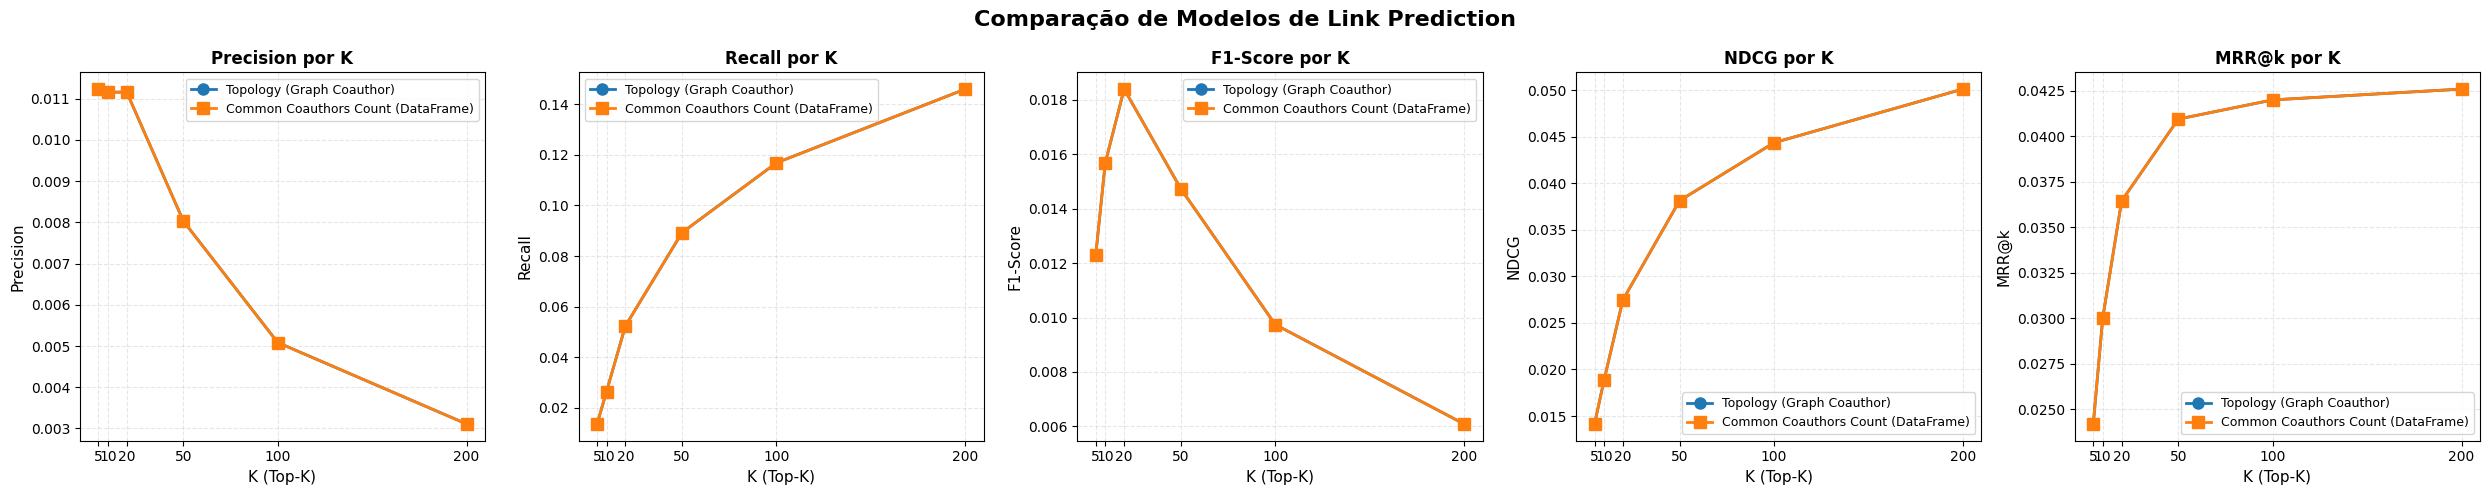

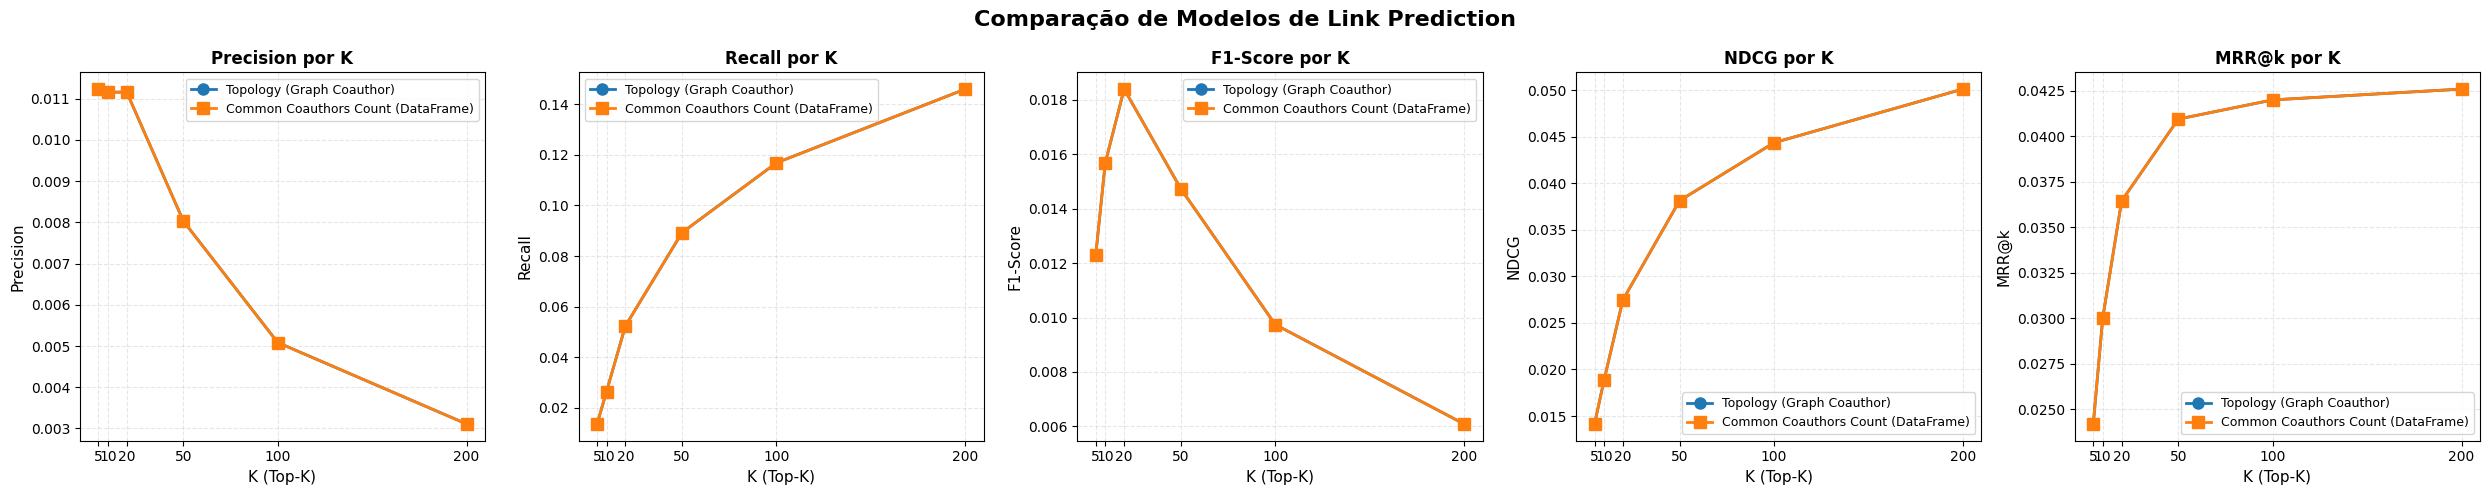

In [35]:
plot_model_comparison(metrics)

In [36]:
# Criação do dataset apenas com pares que são coautores
# Dataset terá: author_a, author_b, count_coauthors, common_coauthors

print("Construindo dicionário de contagem de coautorias...")
coauthor_count = {}

# Construir grafo de coautores para calcular autores em comum
print("Construindo grafo de coautores...")
coauthor_graph = defaultdict(set)

for work_id, group in tqdm(train_df.groupby("work_id"), desc="Processando trabalhos"):
    authors = group["author_id"].tolist()
    if len(authors) > 1:
        # Para cada par de autores no trabalho, incrementar o contador
        for a, b in itertools.combinations(authors, 2):
            # Usar min/max ao invés de sorted (mais rápido)
            pair = (min(a, b), max(a, b))
            coauthor_count[pair] = coauthor_count.get(pair, 0) + 1
            # Construir grafo bidirecional
            coauthor_graph[a].add(b)
            coauthor_graph[b].add(a)

print(f"Total de pares que são coautores: {len(coauthor_count):,}")

# Criar dataset apenas com pares que são coautores
print("\nCriando dataset com pares de coautores e calculando autores em comum...")
rows = []

for (author_a, author_b), count in tqdm(
    coauthor_count.items(), desc="Processando pares"
):
    # Calcular quantidade de autores em comum
    coauthors_a = coauthor_graph.get(author_a, set())
    coauthors_b = coauthor_graph.get(author_b, set())
    # Interseção: autores que são coautores de ambos (excluindo o próprio par)
    common_coauthors = (coauthors_a & coauthors_b) - {author_a, author_b}
    common_count = len(common_coauthors)
    
    rows.append({
        "author_a": author_a, 
        "author_b": author_b, 
        "count_coauthors": count,
        "common_coauthors": common_count
    })

dataset_df = pd.DataFrame(rows)
print(f"\nDataset criado! Total de linhas: {len(dataset_df):,}")
display(dataset_df.head(10))

Construindo dicionário de contagem de coautorias...
Construindo grafo de coautores...


Processando trabalhos: 100%|██████████| 19916/19916 [00:05<00:00, 3737.57it/s]


Total de pares que são coautores: 217,493

Criando dataset com pares de coautores e calculando autores em comum...


Processando pares: 100%|██████████| 217493/217493 [00:01<00:00, 156424.86it/s]



Dataset criado! Total de linhas: 217,493


,author_a,author_b,count_coauthors,common_coauthors
0,https://openalex.org/A5076219710,https://openalex.org/A5103241656,1,4
1,https://openalex.org/A5035579644,https://openalex.org/A5103241656,2,6
2,https://openalex.org/A5069881493,https://openalex.org/A5103241656,2,6
3,https://openalex.org/A5006873642,https://openalex.org/A5103241656,2,6
4,https://openalex.org/A5103241656,https://openalex.org/A5110165399,1,4
5,https://openalex.org/A5035579644,https://openalex.org/A5076219710,1,4
6,https://openalex.org/A5069881493,https://openalex.org/A5076219710,1,4
7,https://openalex.org/A5006873642,https://openalex.org/A5076219710,1,4
8,https://openalex.org/A5076219710,https://openalex.org/A5110165399,1,4
9,https://openalex.org/A5035579644,https://openalex.org/A5069881493,3,8
